# 5G Anomaly Detection

## Initial Imports and Configs

In [2]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
sns.set(style='whitegrid', context='notebook')
import random as rn
import statistics
from scipy import stats as st
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

2023-03-17 16:35:30.450656: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 16:35:30.701998: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-17 16:35:30.760415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-17 16:35:30.760436: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
# https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders
# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED) 
tf.keras.backend.clear_session()

## Pre-Processing

In [4]:
data_frame = pd.read_csv("CHI-JA-WLOOP-ATT-PING-MERGED.csv")
data_frame.info()

/tmp/ipykernel_31084/3996270024.py:1: DtypeWarning: Columns (138,139,146,161,162,169,178,179,186,192,195,202,205,208,215,218,221,228,231,234,241) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frame = pd.read_csv("CHI-JA-WLOOP-ATT-PING-MERGED.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75585 entries, 0 to 75584
Columns: 248 entries, TIME_STAMP to API GPS Info Speed
dtypes: float64(205), object(43)
memory usage: 143.0+ MB


### Data Exploration

In [5]:
missing_vals = data_frame.isna().sum()
for column in missing_vals.index:
    mv = missing_vals[column]
    percent = mv/58615
    print("{}: {}% of missing values ({} total)".format(column,percent,mv))

TIME_STAMP: 0.0% of missing values (0 total)
Lon: 0.0% of missing values (0 total)
Lat: 0.0% of missing values (0 total)
GPS Lon: 0.7725326281668515% of missing values (45282 total)
GPS Lat: 0.7725326281668515% of missing values (45282 total)
GPS Speed (km/h): 0.7725326281668515% of missing values (45282 total)
GPS Distance (m): 0.7728226563166425% of missing values (45299 total)
Event Technology: 0.7635246950439307% of missing values (44754 total)
Event LTE Events: 0.8619636611788791% of missing values (50524 total)
Event 5G-NR Events: 1.0816173334470698% of missing values (63399 total)
LTE KPI Chip Type: 0.7457135545508828% of missing values (43710 total)
LTE KPI PCell Serving PCI: 0.7637635417555233% of missing values (44768 total)
LTE KPI PCell Serving Band: 0.7637635417555233% of missing values (44768 total)
LTE KPI PCell Serving EARFCN(DL): 0.7637635417555233% of missing values (44768 total)
LTE KPI PCell Serving EARFCN(UL): 0.7637635417555233% of missing values (44768 total)
LTE

In [6]:
tech = ["LTE", "LTE(5CA)", 'LTE(4CA)', 'LTE(3CA)','LTE(2CA)', 'UMTS R99', 'NO SERVICE']
data_frame = data_frame[~data_frame["Event Technology"].isin(tech)]
data_frame = data_frame[data_frame['Event Technology'].notna()]
data_frame['Event Technology'].unique()

array(['5G-NR_NSA', '5G-NR_NSA(4CA)', '5G-NR_NSA(7CA)', '5G-NR_NSA(8CA)',
       '5G-NR_NSA(2CA)'], dtype=object)

In [7]:
df = data_frame.copy()
lte = [x for x in df.columns.tolist() if "LTE" in x]
df.drop(lte, axis=1, inplace=True)
scell = [x for x in df.columns.tolist() if "SCell" in x]
df.drop(scell, axis=1, inplace=True)
bbeam = [x for x in df.columns.tolist() if "Best Beam" in x]
df.drop(bbeam, axis=1, inplace=True)

to_drop_columns = ["5G KPI PCell RF NR-ARFCN","5G KPI PCell RF Band","5G KPI PCell RF BandWidth",
                   "5G KPI PCell RF Frequency [MHz]", "5G KPI PCell RF Subcarrier Spacing",
                   "5G KPI PCell RF Duplex Mode", "5G KPI PCell RF Tx Beam ID 0",
                   "5G KPI PCell RF Rx Beam ID 0", "5G KPI PCell RF Rx Beam ID 1",
                   "5G KPI PCell RF Serving PCI-SSB Idx","5G KPI PCell RF Serving SSB Idx",
                   "5G KPI PCell RF RI", "5G KPI PCell RF RI1 Rate [%]","5G KPI PCell RF RI2 Rate [%]",
                   "5G KPI PCell RF RI3 Rate [%]","5G KPI PCell RF RI4 Rate [%]",
                   "5G KPI PCell RF PMI i(1;1)", "5G KPI PCell RF PMI i(1;2)","5G KPI PCell RF PMI i(1;3)", 
                   "5G KPI PCell RF PMI i(2)", "5G KPI PCell RF LI", "5G KPI PCell RF LI1 Rate",
                   "5G KPI PCell RF LI2 Rate", "5G KPI PCell RF LI3 Rate", "5G KPI PCell RF LI4 Rate",
                   "5G KPI PCell RF CRI","5G KPI PCell RF TA", "5G KPI PCell RF SRS Power [dBm]",
                   "5G KPI PCell RF ENDC Tx Power [dBm]", "API GPS Info Estimated accuracy", "API GPS Info Speed"
                   ]
df.drop(to_drop_columns, axis=1, inplace=True)

df['TIME_STAMP'] = df['TIME_STAMP'].astype('datetime64[ns]')

c = df.columns.tolist()
print(df.columns)
print(len(c))
for v in c: print(v)

Index(['TIME_STAMP', 'Lon', 'Lat', 'GPS Lon', 'GPS Lat', 'GPS Speed (km/h)',
       'GPS Distance (m)', 'Event Technology', 'Event 5G-NR Events',
       '5G KPI PCell RF Serving PCI', '5G KPI PCell RF Serving PCI MOD 3',
       '5G KPI PCell RF Serving PCI MOD 4',
       '5G KPI PCell RF Serving PCI MOD 12',
       '5G KPI PCell RF Serving PCI MOD 30',
       '5G KPI PCell RF Serving SS-RSRP [dBm]',
       '5G KPI PCell RF Serving SS-RSRQ [dB]',
       '5G KPI PCell RF Serving SS-SINR [dB]', '5G KPI PCell RF Pathloss [dB]',
       '5G KPI PCell RF CQI', '5G KPI PCell RF PRACH Power [dBm]',
       '5G KPI PCell RF PUSCH Power [dBm]',
       '5G KPI PCell RF PUCCH Power [dBm]',
       '5G KPI PCell RF Neighbor Top1 PCI',
       '5G KPI PCell RF Neighbor Top1 SS-RSRP [dBm]',
       '5G KPI PCell RF Neighbor Top1 SS-RSRQ [dB]',
       '5G KPI PCell RF Neighbor Top2 PCI',
       '5G KPI PCell RF Neighbor Top2 SS-RSRP [dBm]',
       '5G KPI PCell RF Neighbor Top2 SS-RSRQ [dB]',
       '5G KP

In [8]:
df.describe(exclude=['number'])

/tmp/ipykernel_31084/1418341588.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(exclude=['number'])


,TIME_STAMP,Event Technology,Event 5G-NR Events
count,26087,26087,0
unique,17994,5,0
top,2021-06-07 14:06:31,5G-NR_NSA,NaN
freq,2,25733,NaN
first,2021-06-07 11:32:57,NaN,NaN
last,2021-06-08 20:08:42,NaN,NaN


In [9]:
# Taken from tutorial 2 ref[1]
def build_continuous_features_report(data_df):
    
    """Build tabular report for continuous features"""

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }

    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]

    report_df = pd.DataFrame(index=contin_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df


In [10]:
pd.set_option('display.max_rows', None)
build_continuous_features_report(df)

,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
Lon,26087,0.000000,806,-87.633797,-87.630791,-87.629754,-87.629829,-87.628242,-87.626091,0.001699
Lat,26087,0.000000,513,41.876060,41.878101,41.878597,41.878342,41.879250,41.880749,0.000693
GPS Lon,26087,2.066163,764,-87.633800,-87.630790,-87.629749,-87.629830,-87.628230,-87.626090,0.001701
GPS Lat,26087,2.066163,395,41.876060,41.878100,41.878597,41.878340,41.879250,41.880750,0.000694
GPS Speed (km/h),26087,2.066163,21,0.000000,1.000000,2.698607,3.000000,4.000000,43.000000,1.828341
GPS Distance (m),26087,2.081497,532,0.000000,0.830000,2.544385,1.390000,2.000000,198.490000,7.538783
5G KPI PCell RF Serving PCI,26087,0.095833,25,23.000000,334.000000,540.849014,508.000000,686.000000,985.000000,270.139816
5G KPI PCell RF Serving PCI MOD 3,26087,0.095833,3,0.000000,1.000000,1.288504,1.000000,2.000000,2.000000,0.671572
5G KPI PCell RF Serving PCI MOD 4,26087,0.095833,4,0.000000,0.000000,1.466772,2.000000,2.000000,3.000000,1.097502
5G KPI PCell RF Serving PCI MOD 12,26087,0.095833,11,0.000000,2.000000,4.909178,5.000000,7.000000,11.000000,2.637406


In [11]:
df['5G KPI PCell RF Serving PCI'].unique()

array([469.,  nan, 690., 985., 152., 425., 100., 686., 907., 178.,  33.,
       420., 334., 508., 318., 633.,  23., 452., 636., 236., 196., 193.,
       946., 250.,  31., 929.])

In [12]:
df[["5G KPI PCell RF Serving SS-SINR [dB]", "5G KPI PCell RF CQI"]][200:500]

,5G KPI PCell RF Serving SS-SINR [dB],5G KPI PCell RF CQI
577,5.29,8.78
578,4.15,8.56
579,5.89,7.66
580,5.92,7.92
582,11.37,8.70
584,8.99,8.43
585,9.41,8.60
586,5.04,7.94
589,7.32,8.56
591,9.13,9.86


In [13]:
df[['5G KPI PCell RF Serving PCI',"5G KPI PCell RF Serving SS-RSRP [dBm]",
    "5G KPI PCell RF Serving SS-RSRQ [dB]",
    "5G KPI PCell RF Neighbor Top1 SS-RSRP [dBm]",
    "5G KPI PCell RF Neighbor Top1 SS-RSRQ [dB]"]][100:400]

,5G KPI PCell RF Serving PCI,5G KPI PCell RF Serving SS-RSRP [dBm],5G KPI PCell RF Serving SS-RSRQ [dB],5G KPI PCell RF Neighbor Top1 SS-RSRP [dBm],5G KPI PCell RF Neighbor Top1 SS-RSRQ [dB]
339,469.0,-109.24,-12.93,-122.15,-15.97
340,469.0,-110.66,-13.60,-124.04,-17.54
341,469.0,-111.80,-13.63,-125.23,-18.15
342,469.0,-109.06,-12.78,-123.54,-17.18
343,469.0,-108.39,-12.79,-121.97,-16.26
344,469.0,-111.00,-13.59,-124.33,-17.72
345,469.0,-109.77,-12.67,-124.11,-17.32
346,469.0,-113.44,-14.93,-126.08,-18.91
347,469.0,-112.87,-14.49,-127.76,-21.35
348,469.0,-111.14,-13.45,-128.56,-22.77


array([[<AxesSubplot:title={'center':'Lon'}>,
        <AxesSubplot:title={'center':'Lat'}>],
       [<AxesSubplot:title={'center':'GPS Lon'}>,
        <AxesSubplot:title={'center':'GPS Lat'}>],
       [<AxesSubplot:title={'center':'GPS Speed (km/h)'}>,
        <AxesSubplot:title={'center':'GPS Distance (m)'}>],
       [<AxesSubplot:title={'center':'5G KPI PCell RF Serving PCI'}>,
        <AxesSubplot:title={'center':'5G KPI PCell RF Serving PCI MOD 3'}>],
       [<AxesSubplot:title={'center':'5G KPI PCell RF Serving PCI MOD 4'}>,
        <AxesSubplot:title={'center':'5G KPI PCell RF Serving PCI MOD 12'}>],
       [<AxesSubplot:title={'center':'5G KPI PCell RF Serving PCI MOD 30'}>,
        <AxesSubplot:title={'center':'5G KPI PCell RF Serving SS-RSRP [dBm]'}>],
       [<AxesSubplot:title={'center':'5G KPI PCell RF Serving SS-RSRQ [dB]'}>,
        <AxesSubplot:title={'center':'5G KPI PCell RF Serving SS-SINR [dB]'}>],
       [<AxesSubplot:title={'center':'5G KPI PCell RF Pathloss [dB]'}

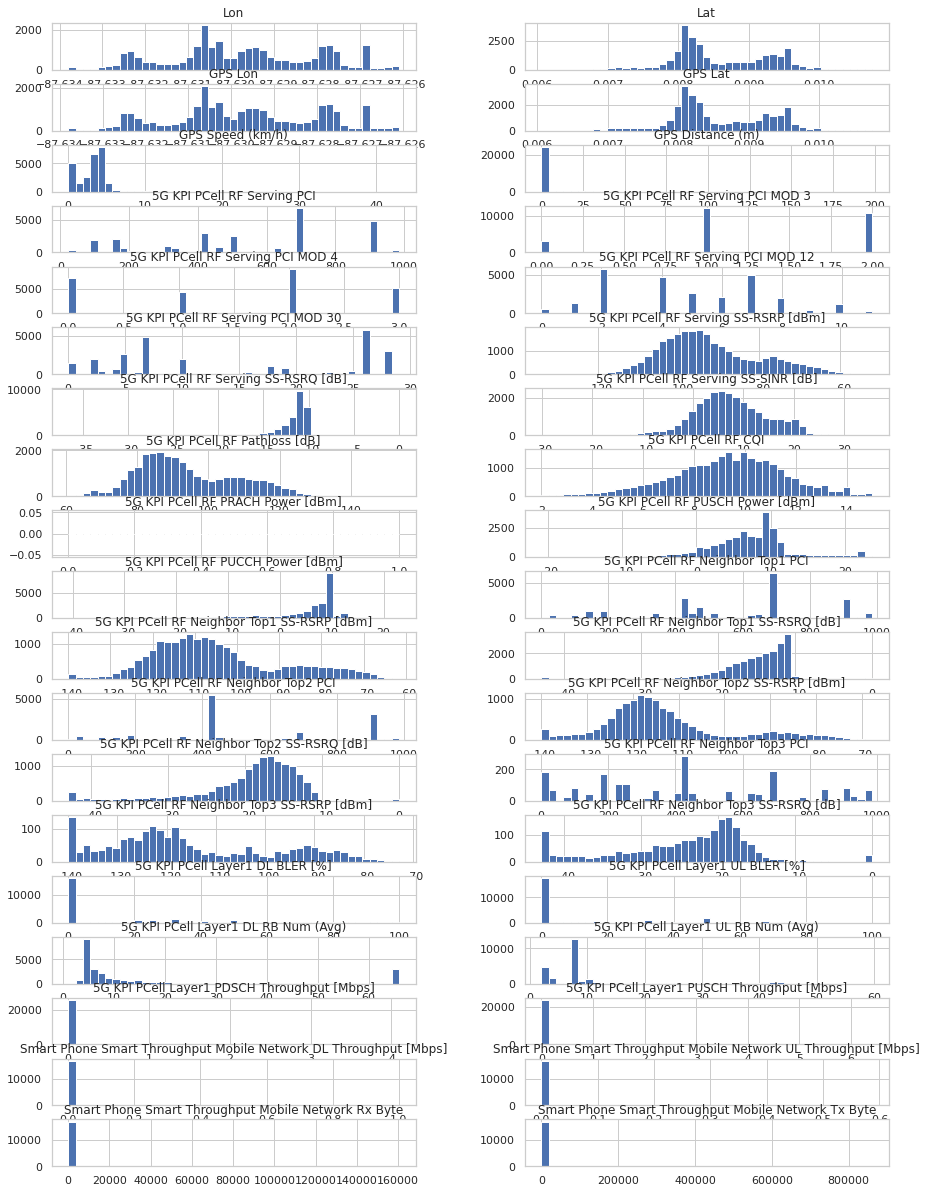

In [14]:
df.select_dtypes('number').hist(figsize=(15, 30), bins=45, layout=(27,2)) 

Text(0.5, 0, 'SINR [dB]')

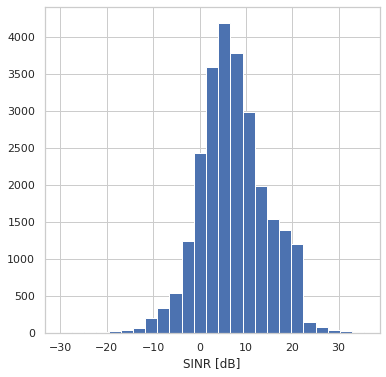

In [15]:
ax = df["5G KPI PCell RF Serving SS-SINR [dB]"].hist(figsize=(6, 6), bins=25) 
ax.set_xlabel("SINR [dB]")

Text(0.5, 0, 'RSRP [dB]')

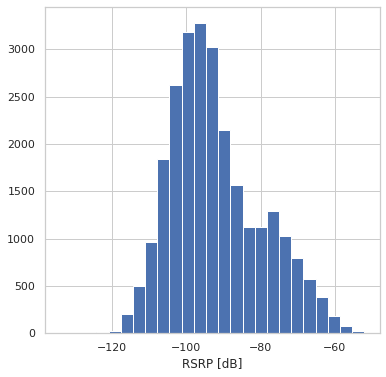

In [16]:
ax = df["5G KPI PCell RF Serving SS-RSRP [dBm]"].hist(figsize=(6, 6), bins=25)
ax.set_xlabel("RSRP [dB]")

Text(0.5, 0, 'RSRQ [dB]')

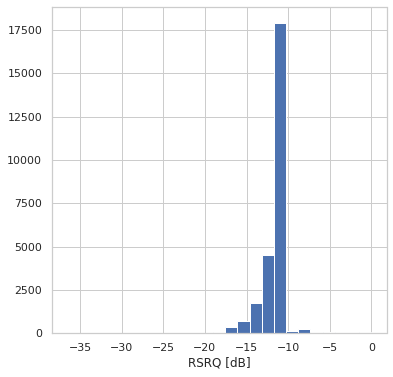

In [17]:
ax = df["5G KPI PCell RF Serving SS-RSRQ [dB]"].hist(figsize=(6, 6), bins=25) 
ax.set_xlabel("RSRQ [dB]")

Text(0.5, 0, 'Throughput')

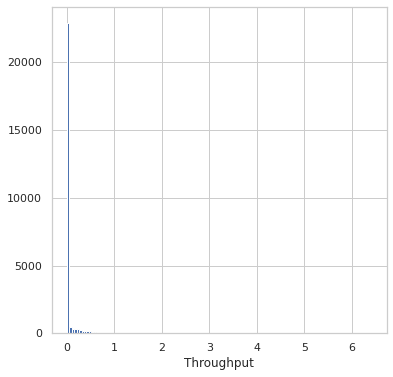

In [18]:
ax = df["5G KPI PCell Layer1 PUSCH Throughput [Mbps]"].hist(figsize=(6, 6), bins=125) 
ax.set_xlabel("Throughput")

### Processing

In [19]:
def one_hot(df, param_list):
    for param in param_list:
        # Get one hot encoding of columns B
        one_hot = pd.get_dummies(df[param])
        # Drop column B as it is now encoded
        df = df.drop(param,axis = 1)
        # Join the encoded df
        df = df.join(one_hot)
    return df

In [20]:
df = one_hot(df, ["Event Technology","Event 5G-NR Events"])


In [21]:
print(len(df))
df.isna().sum()

26087


TIME_STAMP                                                              0
Lon                                                                     0
Lat                                                                     0
GPS Lon                                                               539
GPS Lat                                                               539
GPS Speed (km/h)                                                      539
GPS Distance (m)                                                      543
5G KPI PCell RF Serving PCI                                            25
5G KPI PCell RF Serving PCI MOD 3                                      25
5G KPI PCell RF Serving PCI MOD 4                                      25
5G KPI PCell RF Serving PCI MOD 12                                     25
5G KPI PCell RF Serving PCI MOD 30                                     25
5G KPI PCell RF Serving SS-RSRP [dBm]                                  99
5G KPI PCell RF Serving SS-RSRQ [dB]  

In [22]:
df = df[df['5G KPI PCell RF Serving PCI'].notna()]
to_drop_columns = ["5G KPI PCell RF Neighbor Top1 PCI","5G KPI PCell RF Neighbor Top2 PCI","5G KPI PCell RF Neighbor Top3 PCI"]
df.drop(to_drop_columns, axis=1, inplace=True)

In [23]:
sf = df.loc[:, df.columns != "TIME_STAMP"].interpolate(method ='linear', limit_direction ='backward', limit = 500)
sf["TIME_STAMP"] = df["TIME_STAMP"]
df = sf

In [24]:
l = df.isna().sum()
print(l)

Lon                                                                     0
Lat                                                                     0
GPS Lon                                                                 0
GPS Lat                                                                 0
GPS Speed (km/h)                                                        0
GPS Distance (m)                                                        0
5G KPI PCell RF Serving PCI                                             0
5G KPI PCell RF Serving PCI MOD 3                                       0
5G KPI PCell RF Serving PCI MOD 4                                       0
5G KPI PCell RF Serving PCI MOD 12                                      0
5G KPI PCell RF Serving PCI MOD 30                                      0
5G KPI PCell RF Serving SS-RSRP [dBm]                                   0
5G KPI PCell RF Serving SS-RSRQ [dB]                                    0
5G KPI PCell RF Serving SS-SINR [dB]  

In [25]:
to_drop_columns = [x for x in l.index if l[x] > 500]
df.drop(to_drop_columns, axis=1, inplace=True)


In [26]:
df = df.dropna()
print(len(df))

25740


In [27]:
c = df.columns.tolist()
print(len(c))

34


In [28]:
corr = df.corr()
html = corr.style.background_gradient(cmap='coolwarm').render()
import imgkit
imgkit.from_string(html, 'styled_table.png')

/tmp/ipykernel_31084/1722016428.py:2: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = corr.style.background_gradient(cmap='coolwarm').render()


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

In [29]:
to_drop_columns = ["GPS Lon","GPS Lat", "5G KPI PCell Layer1 UL BLER [%]","5G KPI PCell Layer1 UL RB Num (Avg)",
                   "5G KPI PCell RF PUSCH Power [dBm]","5G KPI PCell RF PUCCH Power [dBm]"]
df.drop(to_drop_columns, axis=1, inplace=True)


/tmp/ipykernel_31084/1574252521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_drop_columns, axis=1, inplace=True)


### Boxplot graphs for behavior checking

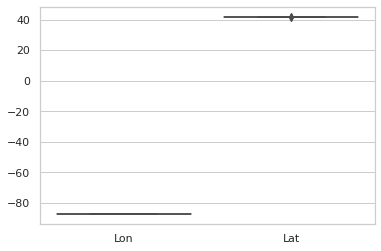

In [29]:
sns.boxplot(data=df[["Lon", "Lat"]])
plt.show()

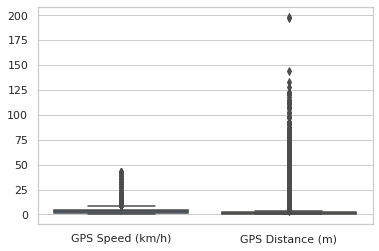

In [170]:
sns.boxplot(data=df[["GPS Speed (km/h)","GPS Distance (m)"]])
plt.show()

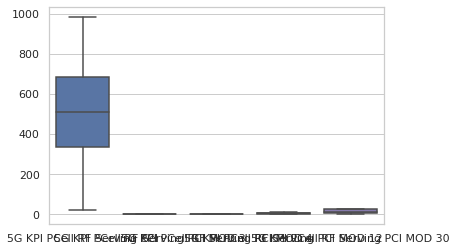

In [171]:
sns.boxplot(data=df[["5G KPI PCell RF Serving PCI",
                     "5G KPI PCell RF Serving PCI MOD 3", "5G KPI PCell RF Serving PCI MOD 4", 
                     "5G KPI PCell RF Serving PCI MOD 12", "5G KPI PCell RF Serving PCI MOD 30"  ]])
plt.show()

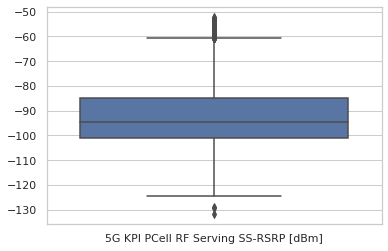

In [172]:
sns.boxplot(data=df[["5G KPI PCell RF Serving SS-RSRP [dBm]"]])
plt.show()

<AxesSubplot:>

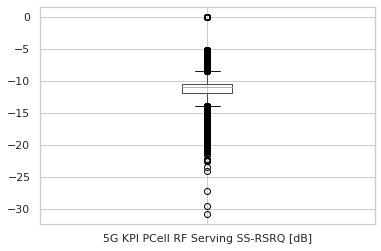

In [173]:
#sns.boxplot(data=df[["5G KPI PCell RF Serving SS-RSRQ [dB]"]])
#plt.show()
df[["5G KPI PCell RF Serving SS-RSRQ [dB]"]].boxplot()

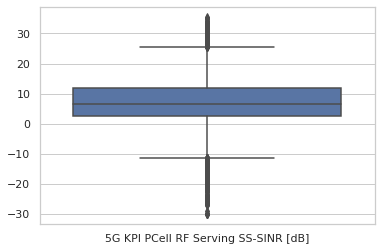

In [174]:
sns.boxplot(data=df[["5G KPI PCell RF Serving SS-SINR [dB]"]])
plt.show()

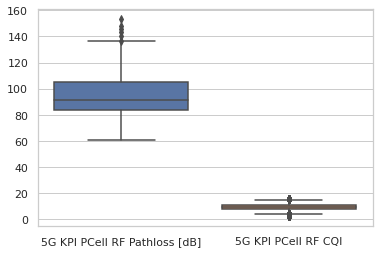

In [175]:
sns.boxplot(data=df[["5G KPI PCell RF Pathloss [dB]","5G KPI PCell RF CQI"]])
plt.show()

In [176]:
#sns.boxplot(data=df[["5G KPI PCell RF PUSCH Power [dBm]","5G KPI PCell RF PUCCH Power [dBm]"]])
#plt.show()

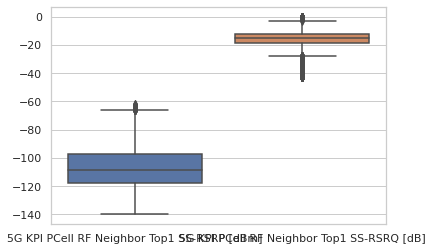

In [177]:
sns.boxplot(data=df[["5G KPI PCell RF Neighbor Top1 SS-RSRP [dBm]","5G KPI PCell RF Neighbor Top1 SS-RSRQ [dB]"]])
plt.show()

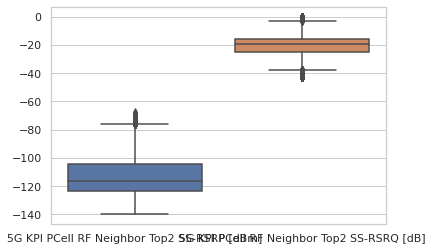

In [178]:
sns.boxplot(data=df[["5G KPI PCell RF Neighbor Top2 SS-RSRP [dBm]","5G KPI PCell RF Neighbor Top2 SS-RSRQ [dB]"]])
plt.show()

In [179]:
#sns.boxplot(data=df[["5G KPI PCell Layer1 DL BLER [%]","5G KPI PCell Layer1 UL BLER [%]"]])
#plt.show()

In [180]:
#sns.boxplot(data=df[["5G KPI PCell Layer1 DL RB Num (Avg)","5G KPI PCell Layer1 UL RB Num (Avg)"]])
#plt.show()

In [181]:
#sns.boxplot(data=df[["5G KPI PCell Layer1 PDSCH Throughput [Mbps]","5G KPI PCell Layer1 PUSCH Throughput [Mbps]"]])
#plt.show()

In [182]:
#df = df.loc[:, df.columns != "TIME_STAMP"]
#print(len(df))
#df = df[(np.abs(st.zscore(df)) < 4).all(axis=1)]
#print(len(df))

In [183]:
print(df.columns.tolist())
print(len(df.columns.tolist()))

['Lon', 'Lat', 'GPS Speed (km/h)', 'GPS Distance (m)', '5G KPI PCell RF Serving PCI', '5G KPI PCell RF Serving PCI MOD 3', '5G KPI PCell RF Serving PCI MOD 4', '5G KPI PCell RF Serving PCI MOD 12', '5G KPI PCell RF Serving PCI MOD 30', '5G KPI PCell RF Serving SS-RSRP [dBm]', '5G KPI PCell RF Serving SS-RSRQ [dB]', '5G KPI PCell RF Serving SS-SINR [dB]', '5G KPI PCell RF Pathloss [dB]', '5G KPI PCell RF CQI', '5G KPI PCell RF Neighbor Top1 SS-RSRP [dBm]', '5G KPI PCell RF Neighbor Top1 SS-RSRQ [dB]', '5G KPI PCell RF Neighbor Top2 SS-RSRP [dBm]', '5G KPI PCell RF Neighbor Top2 SS-RSRQ [dB]', '5G KPI PCell Layer1 DL BLER [%]', '5G KPI PCell Layer1 DL RB Num (Avg)', '5G KPI PCell Layer1 PDSCH Throughput [Mbps]', '5G KPI PCell Layer1 PUSCH Throughput [Mbps]', '5G-NR_NSA', '5G-NR_NSA(2CA)', '5G-NR_NSA(4CA)', '5G-NR_NSA(7CA)', '5G-NR_NSA(8CA)', 'TIME_STAMP']
28


### PCA test (experimental)

['Lon', 'Lat', 'GPS Speed (km/h)', 'GPS Distance (m)', '5G KPI PCell RF Serving PCI', '5G KPI PCell RF Serving PCI MOD 3', '5G KPI PCell RF Serving PCI MOD 4', '5G KPI PCell RF Serving PCI MOD 12', '5G KPI PCell RF Serving PCI MOD 30', '5G KPI PCell RF Serving SS-RSRP [dBm]', '5G KPI PCell RF Serving SS-RSRQ [dB]', '5G KPI PCell RF Serving SS-SINR [dB]', '5G KPI PCell RF Pathloss [dB]', '5G KPI PCell RF CQI', '5G KPI PCell RF Neighbor Top1 SS-RSRP [dBm]', '5G KPI PCell RF Neighbor Top1 SS-RSRQ [dB]', '5G KPI PCell RF Neighbor Top2 SS-RSRP [dBm]', '5G KPI PCell RF Neighbor Top2 SS-RSRQ [dB]', '5G KPI PCell Layer1 DL BLER [%]', '5G KPI PCell Layer1 DL RB Num (Avg)', '5G KPI PCell Layer1 PDSCH Throughput [Mbps]', '5G KPI PCell Layer1 PUSCH Throughput [Mbps]', '5G-NR_NSA', '5G-NR_NSA(2CA)', '5G-NR_NSA(4CA)', '5G-NR_NSA(7CA)', '5G-NR_NSA(8CA)']


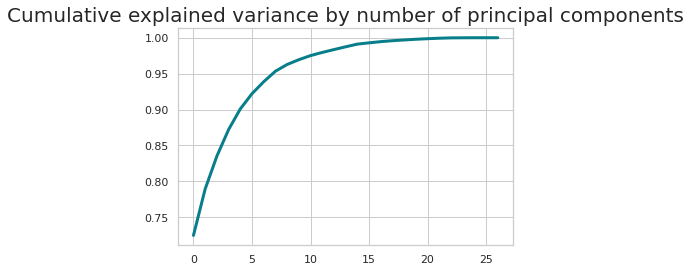

In [30]:
from sklearn.decomposition import PCA


cols = df.select_dtypes(include='number').columns.tolist()
print(cols)
x  = df.select_dtypes(include='number')
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
# get normalization parameters by fitting to the training data
pipeline.fit(x);
x = pipeline.transform(x)

pca = PCA().fit(x)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [31]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(cols) + 1)],
    index=cols
)
loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
Lon,-0.225525,0.009857,0.000586,0.002665,-0.009019,-0.008909,0.006448,-0.018909,0.001352,-0.003850,...,0.005435,-0.000866,0.000215,0.000619,-0.007682,-0.001939,0.000122,-4.196668e-04,4.881038e-06,-1.078812e-06
Lat,0.225522,-0.009856,-0.000593,-0.002658,0.009020,0.008907,-0.006447,0.018909,-0.001352,0.003849,...,-0.005436,0.000866,-0.000214,-0.000620,0.007681,0.001939,-0.000123,4.196922e-04,5.483874e-06,5.930879e-07
GPS Speed (km/h),0.019899,0.000480,0.007460,-0.005439,0.000756,0.001396,-0.003297,-0.003700,0.001492,-0.000881,...,0.002713,0.020086,-0.001220,0.006161,0.000272,-0.000022,-0.000097,-3.879880e-06,1.097080e-10,6.960351e-12
GPS Distance (m),0.007307,0.000437,0.002513,-0.000726,0.000124,0.001945,0.000162,-0.001972,-0.000287,-0.001802,...,-0.000974,-0.004382,-0.000009,-0.000835,-0.000163,0.000005,0.000021,1.204088e-06,-1.561812e-11,-5.174675e-12
5G KPI PCell RF Serving PCI,-0.202426,0.011396,-0.016743,0.009426,0.003840,0.005428,-0.002730,0.004483,0.000748,-0.009297,...,-0.001406,-0.002718,0.000124,-0.001263,-0.000013,0.000013,0.000022,8.745525e-07,-5.837173e-11,-7.636245e-11


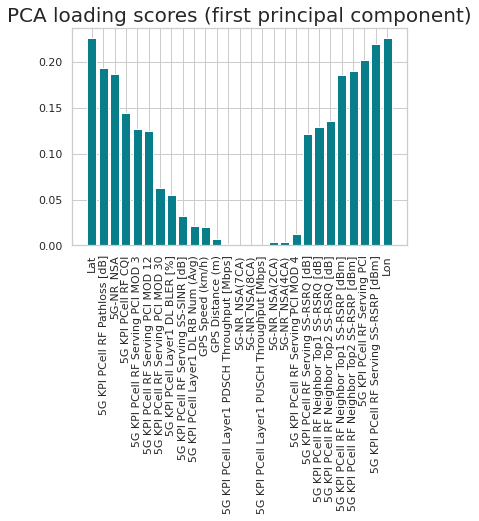

In [32]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=pc1_loadings['Attribute'], height=abs(pc1_loadings['CorrelationWithPC1']), color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [33]:
vals = abs(pc1_loadings['CorrelationWithPC1']).tolist()
attrib = pc1_loadings['Attribute'].tolist()
vals, attrib= zip(*sorted(zip(vals, attrib), reverse=True))


to_drop_columns = []
for i in range(len(vals)):
    print("{} -- {}".format(attrib[i],vals[i]))
    if(vals[i]<0.03 and attrib[i] != "5G KPI PCell Layer1 PDSCH Throughput [Mbps]"): to_drop_columns.append(attrib[i])

print(to_drop_columns)
df.drop(to_drop_columns, axis=1, inplace=True)

Lon -- 0.22552454191284244
Lat -- 0.22552210650798873
5G KPI PCell RF Serving SS-RSRP [dBm] -- 0.21888187960337663
5G KPI PCell RF Serving PCI -- 0.20242608171318058
5G KPI PCell RF Pathloss [dB] -- 0.19323260403978731
5G KPI PCell RF Neighbor Top2 SS-RSRP [dBm] -- 0.18963785997728866
5G-NR_NSA -- 0.18717062202042747
5G KPI PCell RF Neighbor Top1 SS-RSRP [dBm] -- 0.18544208038597054
5G KPI PCell RF CQI -- 0.14420669703007025
5G KPI PCell RF Neighbor Top2 SS-RSRQ [dB] -- 0.13604774755347918
5G KPI PCell RF Neighbor Top1 SS-RSRQ [dB] -- 0.12922996992812094
5G KPI PCell RF Serving PCI MOD 3 -- 0.12718493644143133
5G KPI PCell RF Serving PCI MOD 12 -- 0.12449173389833987
5G KPI PCell RF Serving SS-RSRQ [dB] -- 0.12161889984986272
5G KPI PCell RF Serving PCI MOD 30 -- 0.06307919913418225
5G KPI PCell Layer1 DL BLER [%] -- 0.0551241057231053
5G KPI PCell RF Serving SS-SINR [dB] -- 0.03228564307800304
5G KPI PCell Layer1 DL RB Num (Avg) -- 0.021669174827482162
GPS Speed (km/h) -- 0.0198989056

/tmp/ipykernel_31084/3364050840.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_drop_columns, axis=1, inplace=True)


In [34]:
to_drop_columns = ['5G KPI PCell RF Serving PCI', 
                   '5G KPI PCell RF Serving PCI MOD 3', '5G KPI PCell RF Serving PCI MOD 12',
                   '5G KPI PCell RF Serving PCI MOD 30', 
                   '5G KPI PCell RF Pathloss [dB]',
                   '5G KPI PCell Layer1 DL BLER [%]', '5G-NR_NSA', 'TIME_STAMP']
df.drop(to_drop_columns, axis=1, inplace=True)
print(df.columns.tolist())

['Lon', 'Lat', '5G KPI PCell RF Serving SS-RSRP [dBm]', '5G KPI PCell RF Serving SS-RSRQ [dB]', '5G KPI PCell RF Serving SS-SINR [dB]', '5G KPI PCell RF CQI', '5G KPI PCell RF Neighbor Top1 SS-RSRP [dBm]', '5G KPI PCell RF Neighbor Top1 SS-RSRQ [dB]', '5G KPI PCell RF Neighbor Top2 SS-RSRP [dBm]', '5G KPI PCell RF Neighbor Top2 SS-RSRQ [dB]', '5G KPI PCell Layer1 PDSCH Throughput [Mbps]']


/tmp/ipykernel_31084/2684881155.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_drop_columns, axis=1, inplace=True)


In [35]:
to_drop_columns = [#'Lon', 'Lat', 
                   #'5G KPI PCell RF CQI',
                   #'5G KPI PCell Layer1 PDSCH Throughput [Mbps]',
                   '5G KPI PCell RF Neighbor Top1 SS-RSRP [dBm]', '5G KPI PCell RF Neighbor Top1 SS-RSRQ [dB]',
                   '5G KPI PCell RF Neighbor Top2 SS-RSRP [dBm]', '5G KPI PCell RF Neighbor Top2 SS-RSRQ [dB]']
df.drop(to_drop_columns, axis=1, inplace=True)
print(len(df.columns))
print(df.columns)

7
Index(['Lon', 'Lat', '5G KPI PCell RF Serving SS-RSRP [dBm]',
       '5G KPI PCell RF Serving SS-RSRQ [dB]',
       '5G KPI PCell RF Serving SS-SINR [dB]', '5G KPI PCell RF CQI',
       '5G KPI PCell Layer1 PDSCH Throughput [Mbps]'],
      dtype='object')


/tmp/ipykernel_31084/4024424619.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_drop_columns, axis=1, inplace=True)


In [36]:
print(len(df))

25740


### Creating Synthetic Data

In [37]:
df["Failure"] = 0

/tmp/ipykernel_31084/4128367404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Failure"] = 0


#### Normality Test

In [41]:
# Shapiro-Wilks test
stat, p = shapiro(df["5G KPI PCell RF Serving SS-RSRP [dBm]"].to_numpy())
print('Statistics=%.3f, p=%.8f' % (stat, p))


Statistics=0.965, p=0.00000000


In [40]:
# D’Agostino’s K^2 Test
stat, p = normaltest(df["5G KPI PCell RF Serving SS-RSRP [dBm]"].to_numpy())
print('Statistics=%.3f, p=%.8f' % (stat, p))

Statistics=1400.459, p=0.00000000


In [242]:
result = anderson(df["5G KPI PCell RF Serving SS-RSRP [dBm]"].to_numpy())
print('Statistic: %.3f' % result.statistic)
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 324.240
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


#### Transformation Function

In [176]:
# import data
lte_data = pd.read_csv("db_fm_training.txt")
normal_lte = lte_data.loc[lte_data['FaultCause'] == 7]["RSRP"].to_numpy()
normal_5g = df["5G KPI PCell RF Serving SS-RSRP [dBm]"].to_numpy()

print(len(normal_lte))
print(len(normal_5g))

399
25740


In [258]:
# PARAMETERS
VALIDATE_SIZE = 0.2
BATCH_LTE = 64
BATCH_5G = 64 
LEARN_RATE = 0.0001
EPOCHS = 100

In [259]:
split_point = int(len(normal_lte)*VALIDATE_SIZE)
np.random.shuffle(normal_lte)
np.random.shuffle(normal_5g)
lte_train, lte_validate = normal_lte[split_point:], normal_lte[:split_point]
train_5g, validate_5g = normal_5g[split_point:], normal_5g[:split_point]

# Scale all the data
scaler_lte = MinMaxScaler()
scaler_5g = MinMaxScaler()
lte_train = scaler_lte.fit_transform(lte_train.reshape(-1, 1))
lte_validate = scaler_lte.transform(lte_validate.reshape(-1, 1))
train_5g = scaler_5g.fit_transform(train_5g.reshape(-1,1))
validate_5g = scaler_5g.transform(validate_5g.reshape(-1,1))


# reshape the lte data for the model
train_ds = tf.data.Dataset.from_tensor_slices(
    (lte_train)).shuffle(1000).batch(BATCH_LTE)

test_ds = tf.data.Dataset.from_tensor_slices((lte_validate)).batch(BATCH_LTE)

In [260]:
# Calculate loss based on the mahalanobis distance
def mahalanobis_loss(y_true,y_pred):
    # For a single dimensional array
    # mahalanobis distance = sqrt(((x-mean)^2)/variance)
    variance = tf.cast(tf.math.reduce_variance(y_true), "float32")
    mean =  tf.cast(tf.math.reduce_mean(y_true), "float32")

    diff = tf.math.square(y_pred-mean)
    result = tf.math.sqrt(diff/variance)

    return result

In [275]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d2 = tf.keras.layers.Dense(5, activation='relu')
    #self.d4 = tf.keras.layers.Dense(10, activation='relu')
    #self.d5 = tf.keras.layers.Dense(10, activation='relu')
    #self.d6 = tf.keras.layers.Dense(10, activation='relu')
    self.d3 = tf.keras.layers.Dense(1, activation=None)

  def call(self, x):
    x = self.d2(x)
    #x = self.d4(x)
    #x = self.d5(x)
    #x = self.d6(x)
    x = self.d3(x)
    return x

# Create an instance of the model
model = MyModel()


In [276]:
optimizer = tf.keras.optimizers.SGD(lr=LEARN_RATE)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.KLDivergence(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.KLDivergence(name='test_accuracy')



/home/kvasir/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [277]:
#@tf.function
def train_step(lte, five_g, log_step, log):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(lte, training=True)
    log_step.write(str(five_g.shape)+"\n")
    log_step.write(str(predictions.shape)+"\n")
    loss = mahalanobis_loss(five_g, predictions)

    #write values to a log file if needded
    if(log):
      log_step.write(str(predictions))
      log_step.write("\n")
      log_step.write(str(five_g))
      log_step.write("\n")
      log_step.write(str(loss))
      log_step.write("\n")

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  five_g = scaler_5g.inverse_transform(five_g.numpy())
  predictions = scaler_5g.inverse_transform(predictions.numpy())
  #train_accuracy(five_g, predictions)


In [278]:
#@tf.function
def test_step(lte, five_g):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(lte, training=False)
  t_loss = mahalanobis_loss(five_g, predictions)

  #test_loss(t_loss)
  #test_accuracy(five_g, predictions)


In [279]:
losses_train = []
losses_val = []
f = open("epoch_stats.txt", "w+")
log_step = open("log_step.txt", "w+")
batch_check = open("batch_check.txt", "w+")

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()


  log_step.write("EPOCH {}\n".format(epoch))
  first = True
  for images in train_ds:
    
    # randomly sample from the 5G data points
    # flatten and reshape just to follow the 1d array restriction for np.choice 
    # and keep the shape for the model later
    #labels = tf.constant(np.random.choice(train_5g.flatten(),BATCH_5G).reshape(-1,1))
    labels = tf.constant(np.random.choice(train_5g.flatten(),BATCH_5G).reshape(-1,1))
    batch_check.write(str(labels))
    batch_check.write("\n")

    train_step(images, labels, log_step, first)
    first = False

  #for test_images in test_ds:
  #  test_step(test_images, test_labels)

  losses_train.append(train_loss.result())
  #losses_val.append(test_losslidate,.result())

  f.write(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}\n, '
    #f'Accuracy: {train_accuracy.result() * 100}, '
    #f'Test Loss: {test_loss.result()}, '
    #f'Test Accuracy: {test_accuracy.result() * 100}\n'
  )

f.close()

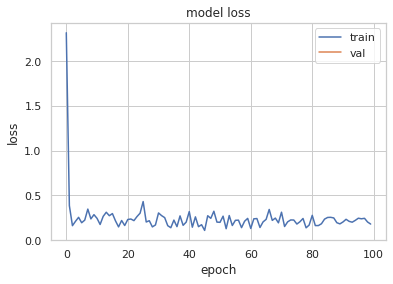

In [280]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

[-90.21012, -90.190834, -90.23033, -90.23134, -90.17888, -90.19365, -90.20346, -90.18549, -90.225105, -90.19562, -90.205826, -90.21814, -90.19933, -90.19576, -90.192535, -90.243355, -90.20917, -90.19477, -90.22644, -90.20228, -90.22209, -90.18702, -90.15732, -90.18522, -90.19642, -90.15476, -90.144516, -90.23267, -90.21632, -90.177505, -90.167114, -90.20159, -90.211205, -90.17402, -90.23016, -90.219, -90.241295, -90.239365, -90.18406, -90.18945, -90.20415, -90.25754, -90.17358, -90.187294, -90.238106, -90.21465, -90.24385, -90.219055, -90.20596, -90.15377, -90.19523, -90.18166, -90.23863, -90.17685, -90.23812, -90.21771, -90.17222, -90.219604, -90.178505, -90.21158, -90.239716, -90.21354, -90.160416, -90.23826, -90.24294, -90.22484, -90.21852, -90.209206, -90.21995, -90.212494, -90.17418, -90.14987, -90.16215, -90.2693, -90.174095, -90.2295, -90.223236, -90.217636, -90.22493]


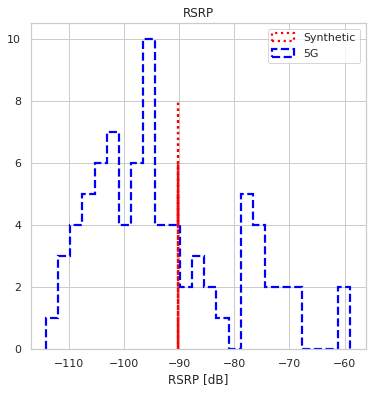

In [281]:
# Plot the validation points on the same axis
results = []
for batch in test_ds:
    predictions = model(batch, training=False)
    results.extend([x[0] for x in scaler_5g.inverse_transform(predictions.numpy())])

print(results)
#values_5g = scaler_lte.inverse_transform(np.random.choice(validate_5g.flatten(),880).reshape(-1,1))
values_5g = scaler_5g.inverse_transform(validate_5g)

fig, ax = plt.subplots(figsize=(6,6))
#ax.hist(results, bins=25, label="Synthetic", alpha=.9, color="blue")
ax.hist(results, bins=25, label="Synthetic", histtype="step", edgecolor='red', linewidth=2.2, linestyle=":")
ax.set_xlabel("RSRP [dB]")
#ax.hist(values_5g,bins=25,label="5G", alpha=.6, color="red")
ax.hist(values_5g, bins=25, label="5G", histtype="step", edgecolor='blue', linewidth=2.2, linestyle="--")
plt.title("RSRP")
plt.legend()
plt.show()

#### CQI MAPPING

In [192]:
cqi_sinr_vals = [-6.936, -5.147, -3.18, -1.253, 0.761, 2.699, 4.694, 6.525, 8.573, 10.366, 12.289, 14.173, 15.888, 17.814, 19.829]

In [193]:
def sinr_to_cqi(sinr_vals):
    cqi_vals = []
    for sinr in sinr_vals:
        cqi = 0
        for cval in cqi_sinr_vals:
            if(sinr<cval): break
            cqi += 1
        cqi_vals.append(cqi)
    return cqi_vals

#### TLHO

In [194]:
rsrp_mean = statistics.mean(df["5G KPI PCell RF Serving SS-RSRP [dBm]"])
rsrp_std = statistics.stdev(df["5G KPI PCell RF Serving SS-RSRP [dBm]"])

#RSRQ
rsrq_mean = statistics.mean(df["5G KPI PCell RF Serving SS-RSRQ [dB]"])
rsrq_std = statistics.stdev(df["5G KPI PCell RF Serving SS-RSRQ [dB]"])

#SINR
sinr_mean = statistics.mean(df["5G KPI PCell RF Serving SS-SINR [dB]"])
sinr_std = statistics.stdev(df["5G KPI PCell RF Serving SS-SINR [dB]"])

#THROUGHPUT
th_mean = statistics.mean(df["5G KPI PCell Layer1 PDSCH Throughput [Mbps]"])
th_std = statistics.stdev(df["5G KPI PCell Layer1 PDSCH Throughput [Mbps]"])



In [195]:
#values extracted from different analysis
nrsrp_mean = -71.82571929824562 
nrsrp_std = 2.007135160913281
nrsrq_mean = -18.133027568922305 
nrsrq_std = 0.25069134908164764
nsinr_mean = 14.854411027568922 
nsinr_std = 0.8323093389221232
nth_mean = 119.09539097744361
nth_std = 13.141634259006995

trsrp_mean = -72.30217647058824 
trsrp_std = 1.6011304618279008
trsrq_mean = -19.010823529411766
trsrq_std = 0.4369024210166337
tsinr_mean = 14.580382352941177 
tsinr_std = 0.9886263201489558
tth_mean = 119.09539097744361
tth_std = 13.141634259006995

In [196]:
def sdcm(mean_desired, std_desired, mean_reference, std_reference, mean_target, std_target, N):
    P = []
    for i in range(N):
        p1 = np.random.normal(mean_desired,std_desired)
        #p1 = v1*std_desired + mean_desired
        d  = (p1-mean_reference)/std_reference
        p2 = d*std_target + mean_target
        P.append(p2)
    return P

In [197]:
rsrp_vals = sdcm(nrsrp_mean, nrsrp_std,nrsrp_mean,nrsrp_std,rsrp_mean,rsrp_std,20000)

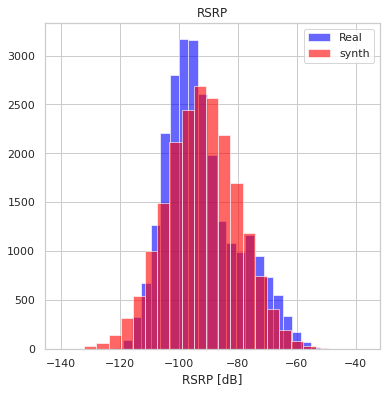

KstestResult(statistic=0.08785163170163168, pvalue=4.977939732041062e-76)


In [198]:
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(df["5G KPI PCell RF Serving SS-RSRP [dBm]"], bins=25, label="Real", alpha=.6, color="blue")
ax.set_xlabel("RSRP [dB]")
ax.hist(rsrp_vals,bins=25,label="synth", alpha=.6, color="red")
plt.title("RSRP")
plt.legend()
plt.show()

from scipy.stats import ks_2samp
print(ks_2samp(df["5G KPI PCell RF Serving SS-RSRP [dBm]"], rsrp_vals))


In [199]:
rsrp_tlho = sdcm(trsrp_mean, trsrp_std,nrsrp_mean,nrsrp_std,rsrp_mean,rsrp_std,50)

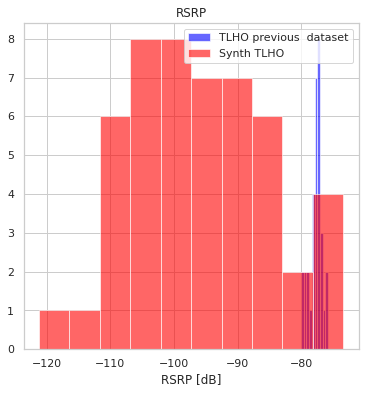

KstestResult(statistic=0.08785163170163168, pvalue=4.977939732041062e-76)


In [200]:
tlho_df = pd.read_csv("db_fm_training.txt")
tlho_df = tlho_df.loc[tlho_df['FaultCause'] == 5]
tlho_vals = tlho_df["RSRP"]

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel("RSRP [dB]")
ax.hist(tlho_vals, bins=10, label="TLHO previous  dataset", alpha=.6, color="blue")
ax.hist(rsrp_tlho,bins=10,label="Synth TLHO", alpha=.6, color="red")

plt.title("RSRP")
plt.legend()
plt.show()

from scipy.stats import ks_2samp
print(ks_2samp(df["5G KPI PCell RF Serving SS-RSRP [dBm]"], rsrp_vals))


In [201]:
synth_df = pd.DataFrame()
sdcm_features = ["5G KPI PCell RF Serving SS-RSRP [dBm]",
                 "5G KPI PCell RF Serving SS-RSRQ [dB]",
                 "5G KPI PCell RF Serving SS-SINR [dB]",
                 "Failure",
                 "5G KPI PCell Layer1 PDSCH Throughput [Mbps]",
                 "5G KPI PCell RF CQI",
                 "TIME_STAMP"]
N = int(len(df)*0.01)
print(N)
for c in df.columns:
    if(c in sdcm_features):continue
    vals = df[c].sample(n=N).tolist()
    synth_df[c] = vals

rsrp_tlho = sdcm(trsrp_mean, trsrp_std,nrsrp_mean,nrsrp_std,rsrp_mean,rsrp_std,N)
rsrq_tlho = sdcm(trsrq_mean, trsrq_std,nrsrq_mean,nrsrq_std,rsrq_mean,rsrq_std,N)
sinr_tlho = sdcm(tsinr_mean, tsinr_std,nsinr_mean,nsinr_std,sinr_mean,sinr_std,N)
cqi_tlho = sinr_to_cqi(sinr_tlho)
th_tlho = sdcm(tth_mean, tth_std,nth_mean,nth_std,th_mean,th_std,N)

synth_df["5G KPI PCell RF Serving SS-RSRP [dBm]"] = rsrp_tlho
synth_df["5G KPI PCell RF Serving SS-RSRQ [dB]"]  = rsrq_tlho
synth_df["5G KPI PCell RF Serving SS-SINR [dB]"]  = sinr_tlho
synth_df["5G KPI PCell Layer1 PDSCH Throughput [Mbps]"]  = th_tlho
synth_df["5G KPI PCell RF CQI"]  = cqi_tlho
synth_df["Failure"]  = 1
    

print(type(synth_df)) 

257
<class 'pandas.core.frame.DataFrame'>


In [202]:
df = pd.concat([df, synth_df])
#X_test, y_test = X_test.drop('Failure', axis=1).values, X_test.Failure.values

In [203]:
print(len(df))

25997


#### Interference

In [204]:
irsrp_mean = -72.8036 
irsrp_std = 2.0407656406358847
irsrq_mean = -18.12686666666667
irsrq_std = 0.19265322905849P [dB]")
ax.hist(v
ith_mean = 119.09539097744361
ith_std = 13.141634259006995

In [205]:
sinr_vals = sdcm(nsinr_mean, nsinr_std,nsinr_mean,nsinr_std,sinr_mean,sinr_std,30000)

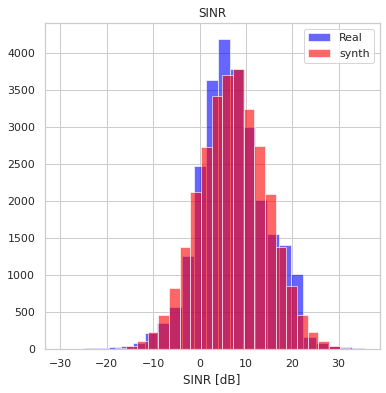

KstestResult(statistic=0.03158486748470979, pvalue=1.6621832125738183e-12)


In [206]:
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(df["5G KPI PCell RF Serving SS-SINR [dB]"], bins=25, label="Real", alpha=.6, color="blue")
ax.set_xlabel("SINR [dB]")
ax.hist(sinr_vals,bins=25,label="synth", alpha=.6, color="red")

plt.title("SINR")
plt.legend()
plt.show()

from scipy.stats import ks_2samp
print(ks_2samp(df["5G KPI PCell RF Serving SS-SINR [dB]"], sinr_vals))


In [207]:
sinr_i = sdcm(isinr_mean, isinr_std,nsinr_mean,nsinr_std,sinr_mean,sinr_std,25)

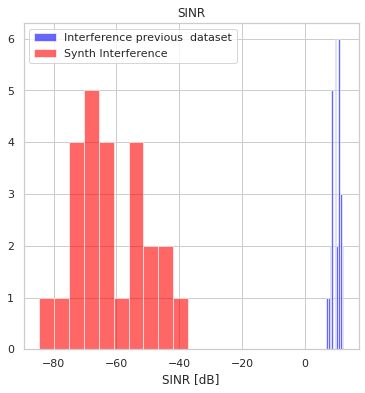

In [208]:
i_df = pd.read_csv("db_fm_training.txt")
i_df = i_df.loc[i_df['FaultCause'] == 6]
i_vals = i_df["SINR"]

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel("SINR [dB]")
ax.hist(i_vals, bins=10, label="Interference previous  dataset", alpha=.6, color="blue")
ax.hist(sinr_i,bins=10,label="Synth Interference", alpha=.6, color="red")

plt.title("SINR")
plt.legend()
plt.show()

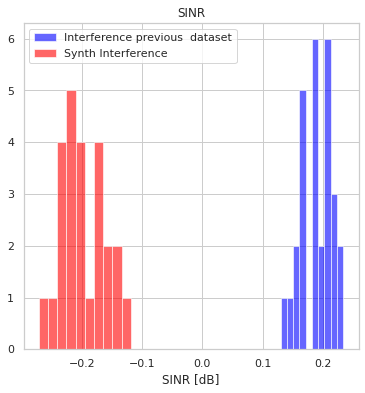

In [209]:
i_norm = preprocessing.normalize([i_vals])[0]
sinr_norm = preprocessing.normalize([sinr_i])[0]

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel("SINR [dB]")
ax.hist(i_norm, bins=10, label="Interference previous  dataset", alpha=.6, color="blue")
ax.hist(sinr_norm,bins=10,label="Synth Interference", alpha=.6, color="red")

plt.title("SINR")
plt.legend()
plt.show()

In [210]:
synth_df = pd.DataFrame()
sdcm_features = ["5G KPI PCell RF Serving SS-RSRP [dBm]",
                 "5G KPI PCell RF Serving SS-RSRQ [dB]",
                 "5G KPI PCell RF Serving SS-SINR [dB]",
                 "Failure",
                 "5G KPI PCell Layer1 PDSCH Throughput [Mbps]",
                 "5G KPI PCell RF CQI",
                 "TIME_STAMP"]
N = int(len(df)*0.01)
print(N)
for c in df.columns:
    if(c in sdcm_features):continue
    vals = df[c].sample(n=N).tolist()
    synth_df[c] = vals
    
rsrp_i = sdcm(irsrp_mean, irsrp_std,nrsrp_mean,nrsrp_std,rsrp_mean,rsrp_std,N)
rsrq_i = sdcm(irsrq_mean, irsrq_std,nrsrq_mean,nrsrq_std,rsrq_mean,rsrq_std,N)
sinr_i = sdcm(isinr_mean, isinr_std,nsinr_mean,nsinr_std,sinr_mean,sinr_std,N)
cqi_i = sinr_to_cqi(sinr_i)
th_i = sdcm(ith_mean, ith_std,nth_mean,nth_std,th_mean,th_std,N)

synth_df["5G KPI PCell RF Serving SS-RSRP [dBm]"] = rsrp_i
synth_df["5G KPI PCell RF Serving SS-RSRQ [dB]"]  = rsrq_i
synth_df["5G KPI PCell RF Serving SS-SINR [dB]"]  = sinr_i
synth_df["5G KPI PCell RF CQI"]  = cqi_i
synth_df["5G KPI PCell Layer1 PDSCH Throughput [Mbps]"]  = th_i
synth_df["Failure"]  = 2
    

print(type(synth_df)) 

259
<class 'pandas.core.frame.DataFrame'>


In [211]:
df = pd.concat([df, synth_df])
#X_test, y_test = X_test.drop('Failure', axis=1).values, X_test.Failure.values

In [212]:
print(len(df))

26256


#### Excessive Power Reduction

In [213]:
prrsrp_mean = -77.27575
prrsrp_std = 1.4264013674667833
prrsrq_mean = -19.130535714285713
prrsrq_std = 0.36678275759615675
prsinr_mean = 9.814321428571429
prsinr_std = 1.3714593215385287
prth_mean = 119.09539097744361
prth_std = 13.141634259006995

In [214]:
synth_df = pd.DataFrame()
sdcm_features = ["5G KPI PCell RF Serving SS-RSRP [dBm]",
                 "5G KPI PCell RF Serving SS-RSRQ [dB]",
                 "5G KPI PCell RF Serving SS-SINR [dB]",
                 "Failure",
                 "5G KPI PCell Layer1 PDSCH Throughput [Mbps]",
                 "5G KPI PCell RF CQI",
                 "TIME_STAMP"]
N = int(len(df)*0.01)
print(N)
for c in df.columns:
    if(c in sdcm_features):continue
    vals = df[c].sample(n=N).tolist()
    synth_df[c] = vals
    
rsrp_pr = sdcm(prrsrp_mean, prrsrp_std,nrsrp_mean,nrsrp_std,rsrp_mean,rsrp_std,N)
rsrq_pr = sdcm(prrsrq_mean, prrsrq_std,nrsrq_mean,nrsrq_std,rsrq_mean,rsrq_std,N)
sinr_pr = sdcm(prsinr_mean, prsinr_std,nsinr_mean,nsinr_std,sinr_mean,sinr_std,N)
cqi_pr = sinr_to_cqi(sinr_pr)
th_pr = sdcm(prth_mean, prth_std,nth_mean,nth_std,th_mean,th_std,N)

synth_df["5G KPI PCell RF Serving SS-RSRP [dBm]"] = rsrp_pr
synth_df["5G KPI PCell RF Serving SS-RSRQ [dB]"]  = rsrq_pr
synth_df["5G KPI PCell RF Serving SS-SINR [dB]"]  = sinr_pr
synth_df["5G KPI PCell RF CQI"]  = cqi_pr
synth_df["5G KPI PCell Layer1 PDSCH Throughput [Mbps]"]  = th_pr
synth_df["Failure"]  = 3
    

print(type(synth_df)) 

262
<class 'pandas.core.frame.DataFrame'>


In [215]:
df = pd.concat([df, synth_df])
#X_test, y_test = X_test.drop('Failure', axis=1).values, X_test.Failure.values

In [216]:
print(len(df))

26518


## Anomaly Detection

### Data Shapping

In [217]:
print(len(df))


# splitting by class
#failures = df[df.Failure != 0]
#real = df[df.Failure == 0]

#FAILURE_TRAINING_SAMPLE = int(len(failures)*train_test_split)
#failure_train = failures.iloc[FAILURE_TRAINING_SAMPLE:] #Failures used for training
#X_failure_train, y_failure_train = failure_train.drop(['Failure', "TIME_STAMP"], axis=1).values, failure_train.Failure.values
#failure = failures.iloc[FAILURE_TRAINING_SAMPLE:] #Failures used for testing

X_train, X_test = train_test_split(df, test_size=0.3, random_state=1)

X_train_normal = X_train[X_train.Failure==0].drop('Failure',axis=1)
X_train_failure = X_train[X_train.Failure!=0]

X_test, y_test = X_test.drop('Failure', axis=1).values, X_test.Failure.values
X_train_failure, y_train_failure = X_train_failure.drop('Failure', axis=1).values, X_train_failure.Failure.values


# training set: exlusively non-fraud transactions
#X_train = df.iloc[:TRAINING_SAMPLE].drop('Failure', axis=1)

# testing  set: the remaining non-fraud + all the fraud 
#X_test = df.iloc[TRAINING_SAMPLE:]

print("Train size: {}".format(len(X_train)))
print("Test size: {}".format(len(X_test)))

26518
Train size: 18562
Test size: 7956


In [218]:
# train // validate - no labels since they're all clean anyway
X_train_normal, X_validate = train_test_split(X_train_normal, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

### Model Settings

In [219]:


# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
# get normalization parameters by fitting to the training data
pipeline.fit(X_train_normal.loc[:, X_train_normal.columns != "TIME_STAMP"]);

# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train_normal.loc[:, X_train_normal.columns != "TIME_STAMP"])
#X_train_transformed["TIME_STAMP"] = X_train["TIME_STAMP"]
X_validate_transformed = pipeline.transform(X_validate.loc[:, X_validate.columns != "TIME_STAMP"])
#X_validate_transformed["TIME_STAMP"] = X_validate["TIME_STAMP"]


In [220]:
# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 128
EPOCHS = 200

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(8,activation='elu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4,activation='elu'), 
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(4,activation='elu'), 
    
    # reconstruction / decode
    #tf.keras.layers.Dense(8,activation='elu'), 
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8,activation='elu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(input_dim,activation='elu')
    
])

autoencoder.build([None,input_dim])
# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 64        
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 4)                 36        
                                                                 
 dense_6 (Dense)             (None, 8)                 40        
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 7)                 63        
                                                                 
Total params: 203
Trainable params: 203
Non-trainable 

In [221]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)

# callbacks argument only takes a list
#cb = [early_stop, save_model, tensorboard]
cb = [save_model, tensorboard]



### Training

In [222]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=False,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Epoch 1/200
113/113 [==============================] - 2s 7ms/step - loss: 0.0888 - acc: 0.2155 - val_loss: 0.0179 - val_acc: 0.2764
Epoch 2/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0343 - acc: 0.3067 - val_loss: 0.0104 - val_acc: 0.6672
Epoch 3/200
113/113 [==============================] - 1s 5ms/step - loss: 0.0219 - acc: 0.4146 - val_loss: 0.0062 - val_acc: 0.6625
Epoch 4/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0161 - acc: 0.4690 - val_loss: 0.0048 - val_acc: 0.6764
Epoch 5/200
113/113 [==============================] - 1s 5ms/step - loss: 0.0123 - acc: 0.4926 - val_loss: 0.0037 - val_acc: 0.6839
Epoch 6/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0101 - acc: 0.5313 - val_loss: 0.0030 - val_acc: 0.6958
Epoch 7/200
113/113 [==============================] - 1s 5ms/step - loss: 0.0083 - acc: 0.5630 - val_loss: 0.0026 - val_acc: 0.7313
Epoch 8/200
113/113 [==============================] - 1s 5ms/step - 

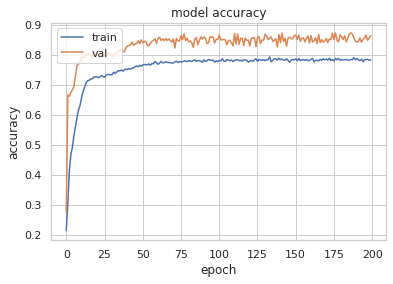

In [223]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

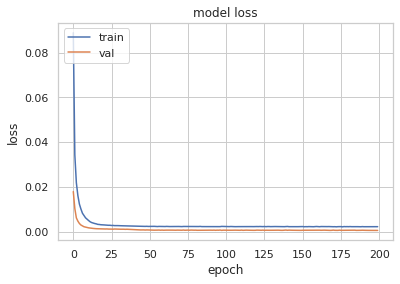

In [224]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [225]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

print(len(X_test_transformed))
# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

7956
  1/249 [..............................] - ETA: 32s

/home/kvasir/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


249/249 [==============================] - 1s 2ms/step


In [226]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
print(mse)

[8.67520803e-05 5.95109955e-04 1.90770661e-04 ... 6.01077843e-05
 1.05307324e-04 1.57000560e-05]


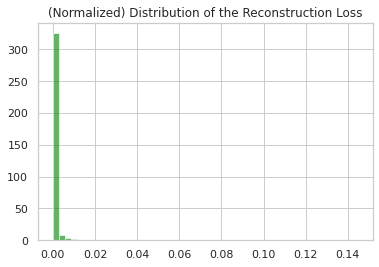

In [227]:

plt.hist(mse,bins=50, density=True, alpha=.6, color="green")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.show()


In [228]:
real = mse[y_test==0]
synth = mse[y_test!= 0]
print(len(real))

7727


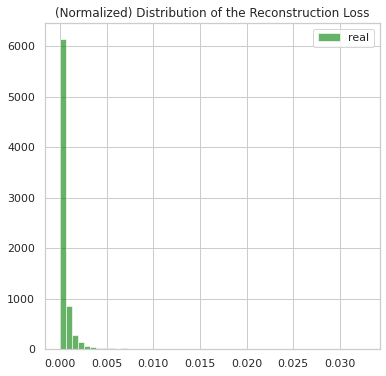

In [229]:
fig, ax = plt.subplots(figsize=(6,6))

#ax.hist(synth, bins=50, density=True, stacked= True,label="synth", alpha=.6, color="red")
ax.hist(real, bins=50, density=False, label="real", alpha=.6, color="green")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()


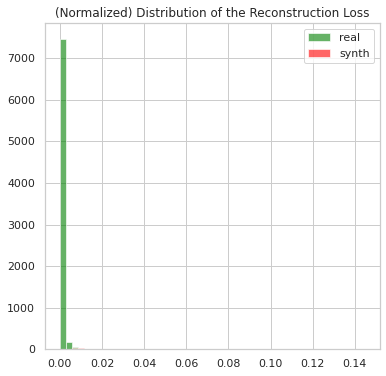

In [230]:
fig, ax = plt.subplots(figsize=(6,6))

bins=np.histogram(np.hstack((real,synth)), bins=50)[1]
ax.hist(real,bins, label="real", alpha=.6, color="green")
ax.hist(synth,bins,label="synth", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()


In [231]:
THRESHOLD =15.

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [232]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

y_test_p = []
print(y_test)
for v in y_test:
    if(v == 0): y_test_p.append(False)
    else: y_test_p.append(True)

# get (mis)classification
cm = confusion_matrix(y_test_p, outliers)

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()


[0 0 0 ... 0 0 0]


The classifications using the MAD method with threshold=15.0 are as follows:
[[7558  169]
 [  20  209]]

% precision:                     209/(169+209)                = 55.29%
% recall:                        209/(20+209)                 = 91.27%
% percentage of false alarms:    169/(7558+169)               = 2.19%
% accuracy :                     209+7558/(20+169+7558+209)   = 97.62%


<AxesSubplot:>

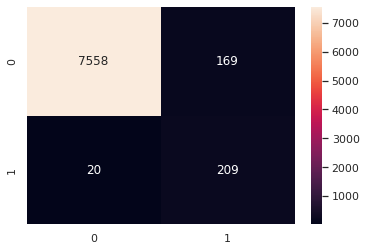

In [233]:


print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% precision:                     {tp}/({fp}+{tp})                = {tp/(fp+tp):.2%}
% recall:                        {tp}/({fn}+{tp})                 = {tp/(fn+tp):.2%}
% percentage of false alarms:    {fp}/({tn}+{fp})               = {fp/(tn+fp):.2%}
% accuracy :                     {tp}+{tn}/({fn}+{fp}+{tn}+{tp})   = {(tp+tn)/(fn+fp+tn+tp):.2%}""")

sns.heatmap(cm, annot=True, fmt='.5g')

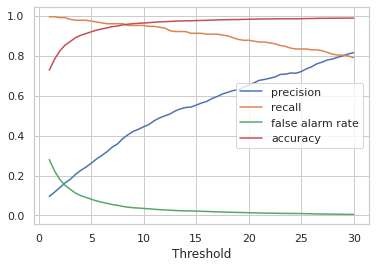

In [234]:
precision_vals = []
recall_vals = []
fa_vals = []
acc_vals = []
th_vals = [x / 10.0 for x in range(10, 305, 5)]

for th in th_vals:
    outliers_v = z_scores > th

    cm = confusion_matrix(y_test_p, outliers_v)

    # true/false positives/negatives
    (tn, fp, 
    fn, tp) = cm.flatten()
    precision = tp/(fp+tp)
    recall = tp/(fn+tp)
    fa = fp/(tn+fp)
    acc = (tp+tn)/(fn+fp+tn+tp)

    precision_vals.append(precision)
    recall_vals.append(recall)
    fa_vals.append(fa)
    acc_vals.append(acc)

plt.plot(th_vals, precision_vals, label="precision")
plt.plot(th_vals, recall_vals, label="recall")
plt.plot(th_vals, fa_vals, label="false alarm rate")
plt.plot(th_vals, acc_vals, label="accuracy")
plt.xlabel("Threshold")
plt.legend()
plt.show()


## RCA (Classifier Model)

In [235]:
outlier_vals = []
y_test_vals = []
for i in range(len(outliers)):
    if(outliers[i]):
        outlier_vals.append(X_test[i])
        y_test_vals.append(y_test[i])

[3 2 2 1 1 3 1 2 3 2 3 1 3 3 1 2 2 2 1 3 3 3 2 3 1 2 1 3 2 1 2 1 1 1 1 1 1
 3 3 3 1 1 1 3 1 3 2 2 3 1 3 2 2 3 1 1 2 1 2 2 1 3 2 3 3 1 2 2 3 1 2 1 2 1
 1 1 3 1 3 1 1 1 2 3 3 3 2 1 1 3 3 3 3 3 3 2 2 2 1 1 2 2 1 1 3 1 1 1 1 1 2
 2 3 3 2 3 2 1 3 3 1 3 2 2 2 2 1 2 2 2 3 1 3 2 3 1 1 2 1 1 2 2 2 1 3 1 1 2
 1 2 1 1 3 1 1 2 3 1 2 3 2 3 2 2 2 2 2 3 2 1 1 2 1 2 3 2 1 2 3 2 2 1 3 1 2
 1 3 3 3 1 3 2 1 1 1 2 1 2 2 1 2 1 3 1 2 3 3 1 3 1 2 1 1 3 2 1 2 1 3 2 2 2
 3 3 3 3 2 1 2 3 1 3 3 2 3 1 2 3 1 1 3 3 2 2 1 3 1 1 2 1 1 2 3 1 2 3 3 2 3
 3 3 2 2 2 3 1 1 1 2 1 3 3 2 1 3 1 2 1 3 3 3 2 3 1 2 1 3 2 2 1 3 3 2 3 2 1
 3 3 3 1 1 3 3 1 2 1 1 3 1 2 2 3 1 3 1 1 3 2 2 3 2 2 2 2 3 1 3 1 1 3 3 1 3
 2 1 2 2 3 2 3 2 3 3 2 3 1 2 1 3 3 3 3 1 1 3 1 3 1 3 2 2 1 2 1 1 1 3 1 1 1
 1 1 3 2 3 1 3 2 1 2 1 3 1 2 3 3 2 2 2 2 2 2 3 2 1 1 2 1 3 3 3 3 1 2 3 2 1
 2 3 1 2 2 3 1 1 3 2 1 3 2 3 2 1 1 3 2 3 3 3 1 3 2 3 3 2 1 2 3 2 3 3 3 2 1
 2 3 3 2 2 1 2 1 1 2 2 3 1 3 3 3 1 2 3 1 3 2 3 1 2 1 3 3 2 3 3 1 3 3 3 1 3
 2 3 1 3 2 1 1 2 1 1 3 2 

<AxesSubplot:>

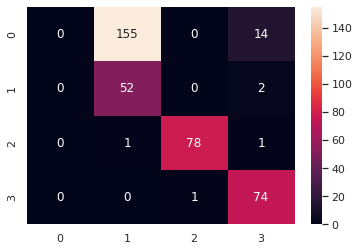

In [236]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train_failure, y_train_failure)
print(y_train_failure)

#Predict the response for test dataset
y_pred_f = clf.predict(outlier_vals)
print("Accuracy:",metrics.accuracy_score(y_test_vals, y_pred_f))
cm = confusion_matrix(y_test_vals, y_pred_f)
sns.heatmap(cm, annot=True,  fmt='.5g') # font size

In [237]:
correct_pred = 0
preds = 0
y_test_vals, y_pred_f
for i in range(len(y_pred_f)):
    if(y_test_vals[i] == 0): continue
    if(y_test_vals[i] == y_pred_f[i]): correct_pred += 1
    preds += 1

print("Accuracy on failure cases: {}".format(correct_pred/preds))

Accuracy on failure cases: 0.9760765550239234
